In [57]:
import numpy as np
from scipy.stats import norm

In [58]:
def black_call(f,k,sigma,t):
    sigmasqdt = sigma * np.sqrt(t)
    d1 = np.log(f/k) / sigmasqdt + 0.5 * sigmasqdt
    return f*norm.cdf(d1,0,1)-k*norm.cdf(d1 - sigmasqdt,0,1)

def black(df,f,k,sigma,t,pc):
    sigmasqdt = sigma * np.sqrt(t)
    d1 = np.log(f/k) / sigmasqdt + 0.5 * sigmasqdt
    return df*(pc*f*norm.cdf(pc*d1,0,1)-pc*k*norm.cdf(pc*(d1 - sigmasqdt),0,1))

def black_vega(df,f,k,sigma,t):
    sigmasqdt = sigma * np.sqrt(t)
    d1 = np.log(f/k) / sigmasqdt + 0.5 * sigmasqdt
    return df*(f*norm.pdf(d1,0,1)*np.sqrt(t))

def digital_call(f,k,sigma,t):
    sigmasqdt = sigma * np.sqrt(t)
    d1 = np.log(f/k) / sigmasqdt + 0.5 * sigmasqdt
    d2 = d1 - sigmasqdt
    return norm.cdf(d2,0,1)

def digital_put(f,k,sigma,t):
    return 1.-digital_call(f,k,sigma,t)

def digital_vega(f,k,sigma,t):
    sigmasqdt = sigma * np.sqrt(t)
    d1 = np.log(f/k) / sigmasqdt + 0.5 * sigmasqdt
    d2 = d1 - sigmasqdt
    return norm.pdf(d2)*d1/sigma

In [59]:
print(black(1.,1.,1.,0.2,1.,1.))
print(black(1.,1.,1.,0.2,1.,-1.))

0.07965567455405798
0.07965567455405798


In [60]:
def implied_black(df,f,k,price,t,pc):
    #x(n+1) = x(n) - f(x(n))/f'(x(n))
    #f(x) = f(x0) + f'(x0) (x-x0)
    #(x-x0) = f(x0)/f'(x0)
    #x = x0 - f(x0)/f'(x0)
    x = 0.3
    fx = black(df,f,k,x,t,pc) - price
    fp = black_vega(df,f,k,x,t)
    while abs(fx) > 0.00001:
        x = x - fx / fp
        fx = black(df,f,k,x,t,pc) - price
        fp = black_vega(df,f,k,x,t)

    return x

In [61]:
print(implied_black(1,1,1,0.08,1,1))
print(implied_black(1,1,1,0.08,1,-1))

0.2008674383141988
0.2008674383141988


In [62]:
from scipy.interpolate import interp1d
import time

In [63]:
def construct_fwd(S,r,q,div,expiry,num):
    x = np.linspace(0, expiry, num, endpoint=True)
    y = S*np.exp(x*(r-q)) 
    
    N = np.size(div,0)*2 + 2
    #to work with vector we need to init the arrays using numpy
    x =  np.asarray([0.0 for i in range(N)])
    y =  np.asarray([0.0 for i in range(N)])      
    y[0] = S
    
    eps = 0.0001    
    
    for i,it in enumerate(div):
        #Discrete dividend jump
        x[2*i+1] = it[0] - eps        
        y[2*i+1] = y[2*i] * np.exp((x[2*i+1]-x[2*i])*(r-q))

        x[2*i+2] = it[0]
        y[2*i+2] = y[2*i+1] - it[1]
        
    x[N-1] = expiry
    y[N-1] = y[2*i+2] * np.exp((x[N-1]-x[N-2])*(r-q))     
        
    fwd = interp1d(x, y)
    return fwd

In [64]:
def binomial_tree(pc, fwd, K, r, sigma, T, N=2000, american="false"):
    #Improve the previous tree by checking for early exercise for american options
   
    #calculate delta T    
    deltaT = float(T) / N
 
    # up and down factor will be constant for the tree so we calculate outside the loop
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
 
    #to work with vector we need to init the arrays using numpy
    fs =  np.asarray([0.0 for i in range(N + 1)])
        
    #we need the stock tree for calculations of expiration values
    fs2 = np.asarray([(u**j * d**(N - j)) for j in range(N + 1)])
    
    #we vectorize the strikes as well so the expiration check will be faster
    fs3 = np.asarray( [float(K) for i in range(N + 1)])
    
    dts = np.asarray([(j * deltaT) for j in range(N + 1)])
         
    #rates are fixed so the probability of up and down are fixed.
    #this is used to make sure the drift is the risk free rate
    a = 1
    p = (a - d)/ (u - d)
    oneMinusP = 1.0 - p
   
    # Compute the leaves, f_{N, j}
    fs[:] = np.maximum(pc*fwd*fs2-pc*fs3, 0.0)
      
    #calculate backward the option prices
    df = np.exp(-r * deltaT)
    for i in range(N-1, -1, -1):
        fs[:-1]= df * (p * fs[1:] + oneMinusP * fs[:-1])
        fs2[:]=fs2[:]*u
        f = fwd
      
        if american=='true':
        #Simply check if the option is worth more alive or dead
            fs[:]=np.maximum(fs[:],pc*f*fs2[:]-pc*fs3[:])
                
    return fs[0]

In [65]:
def binomial_tree_control_variate(pc, fwd, K, r, sigma, T, N=2000, american="false", control_variate="true", 
                                  importance_sampling = "false"):
    #Improve the previous tree by checking for early exercise for american options
   
    #calculate delta T    
    deltaT = float(T) / N
    fx = fwd
    # up and down factor will be constant for the tree so we calculate outside the loop
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
       
    factor = 1
    if importance_sampling == "true":
        factor = np.power(K/fx,1/N)
        u = u * factor
        d = d * factor
 
    #to work with vector we need to init the arrays using numpy
    fs    =  np.asarray([0.0 for i in range(N + 1)])
    fs_cv =  np.asarray([0.0 for i in range(N + 1)])    
        
    #we need the stock tree for calculations of expiration values
    fs2 = np.asarray([(u**j * d**(N - j)) for j in range(N + 1)])
       
    #we vectorize the strikes as well so the expiration check will be faster
    fs3 = np.asarray( [float(K) for i in range(N + 1)])
    
    dts = np.asarray([(j * deltaT) for j in range(N + 1)])
   
    #rates are fixed so the probability of up and down are fixed.
    #this is used to make sure the drift is the risk free rate
    a = 1
    p = (a - d)/ (u - d)
    oneMinusP = 1.0 - p
       
    # Compute the leaves, f_{N, j}
    fs[:]    = np.maximum(pc*fwd*fs2-pc*fs3, 0.0)
    fs_cv[:] = np.maximum(pc*fwd*fs2-pc*fs3, 0.0)
    
    #calculate backward the option prices
    df = np.exp(-r * deltaT)
    for i in range(N-1, -1, -1):
        # propagate American and European 
        fs[:-1]    = df * (p * fs[1:]    + oneMinusP * fs[:-1])
        fs_cv[:-1] = df * (p * fs_cv[1:] + oneMinusP * fs_cv[:-1])      
        
        fs2[:]=fs2[:]*u/factor/factor
        f = fwd
      
        #Simply check if the option is worth more alive or dead
        fs[:]=np.maximum(fs[:],pc*f*fs2[:]-pc*fs3[:])

    if american=='true': 
        if control_variate=='true':
            fx = fwd
            df = np.exp(-r*T)
            b = black(df,fx,K,sigma,T,pc)
            return fs[0] - fs_cv[0] + b
        else:
            return fs[0]
    else:
        return fs_cv[0]

In [11]:
@tf.function(experimental_compile=True)
def binomial_tree(pc, fwd, K, r, sigma, T, N=2000, american="false"):
    #Improve the previous tree by checking for early exercise for american options
   
    #calculate delta T    
    deltaT = float(T) / N
 
    # up and down factor will be constant for the tree so we calculate outside the loop
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
 
    #to work with vector we need to init the arrays using numpy
    fs =  np.asarray([0.0 for i in range(N + 1)])
        
    #we need the stock tree for calculations of expiration values
    fs2 = np.asarray([(u**j * d**(N - j)) for j in range(N + 1)])
    
    #we vectorize the strikes as well so the expiration check will be faster
    fs3 = np.asarray( [float(K) for i in range(N + 1)])
    
    dts = np.asarray([(j * deltaT) for j in range(N + 1)])
         
    #rates are fixed so the probability of up and down are fixed.
    #this is used to make sure the drift is the risk free rate
    a = 1
    p = (a - d)/ (u - d)
    oneMinusP = 1.0 - p
   
    # Compute the leaves, f_{N, j}
    fs[:] = np.maximum(pc*fwd*fs2-pc*fs3, 0.0)
      
    #calculate backward the option prices
    df = np.exp(-r * deltaT)
    for i in range(N-1, -1, -1):
        fs[:-1]= df * (p * fs[1:] + oneMinusP * fs[:-1])
        fs2[:]=fs2[:]*u
        f = fwd
      
        if american=='true':
        #Simply check if the option is worth more alive or dead
            fs[:]=np.maximum(fs[:],pc*f*fs2[:]-pc*fs3[:])
                
    return fs[0]

In [222]:
r = 0.05
q = 0.03
expiry = 1
num = 100
sigma = 0.4
S = 100
    
strike = 100

t1 = time.clock()

#div = [[0.25, 3],[0.5, 3], [0.75, 3]]
div = [[0.25, 0],[0.5, 0], [0.75, 0]]
fwd = S
df = np.exp(-r*expiry)

bt_call_eu = binomial_tree(1,fwd,strike,r,sigma,expiry,num,"false")
bt_call_am = binomial_tree(1,fwd,strike,r,sigma,expiry,num,"true")    
bt_put_eu = binomial_tree(-1,fwd,strike,r,sigma,expiry,num,"false")
bt_put_am = binomial_tree(-1,fwd,strike,r,sigma,expiry,num,"true")
call = black(df,fwd,strike,sigma,expiry,1)
put = black(df,fwd,strike,sigma,expiry,-1)    

bt_put_eu_cv = binomial_tree_control_variate(-1,fwd,strike,r,sigma,expiry,num,"false","true")
bt_put_am_cv = binomial_tree_control_variate(-1,fwd,strike,r,sigma,expiry,num,"true","true")
bt_put_am_cv_is = binomial_tree_control_variate(-1,fwd,strike,r,sigma,expiry,num,"true","true","true")
bt_put_am_is = binomial_tree_control_variate(-1,fwd,strike,r,sigma,expiry,num,"true","false","true")

print(bt_put_am)
print(bt_put_am_cv)
print(bt_put_am_cv_is)
print(bt_put_am_is)
print(put)
price_am = bt_put_am + (put - bt_put_eu)

tf.Tensor(15.218373235646823, shape=(), dtype=float64)
15.256018630589418
15.256018630589418
15.218373235646823
15.07883355917036


In [1]:
import time

In [2]:
num = 200
%timeit binomial_tree(1,fwd,strike,r,sigma,expiry,num,"false")

NameError: name 'binomial_tree' is not defined

In [14]:
import tensorflow as tf
import numpy as np

In [15]:
a = [1,2]
b = tf.convert_to_tensor(a)
c = tf.pad(b,[[0,2]])
c

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 0, 0])>

In [128]:
sigma = 0.2
T = 1
N = 500

#calculate delta T    
deltaT = T / N

# up and down factor will be constant for the tree so we calculate outside the loop
u = tf.exp(sigma * np.sqrt(deltaT))
d = 1.0 / u

a = 1
p = (a - d)/ (u - d)

fs2 = np.asarray([(u**j * d**(N - j)) for j in range(N + 1)])

@tf.function(experimental_compile=True)
def binomial_tree_tf(pc, fwd, K, p, fs2, N=2000):
    fs_t = tf.TensorArray(size=N+1, dtype=tf.float64)

   # Call option at maturity
    fs_t = fs_t.write(N, tf.maximum(pc*fwd*fs2 - pc*K, 0.0))

    oneMinusP = 1.0 - p
    
    for i in range(N-1, -1, -1):
        z = fs_t.read(i+1)
        # Compute the continuation value and compare with early exercise
        fs_t = fs_t.write(i, p*tf.roll(z,shift=-1,axis=1) + oneMinusP*z)   

    return fs_t.stack()

In [129]:
sigma_t = tf.constant(0.2, dtype=tf.float64)
fwd_t = tf.constant(100., dtype=tf.float64)

strike = tf.constant([[95.],[96.],[97.],[98.],[99.],[100.],[101],[102]], dtype=tf.float64)
r = 0.05
expiry = 1

fs2_t = tf.convert_to_tensor([fs2,fs2,fs2,fs2,fs2,fs2,fs2,fs2])

v = binomial_tree_tf(tf.constant(1.,dtype=tf.float64),fwd_t,strike,p,fs2_t,tf.constant(N))
#dy_dx = g.gradient(v, fwd_t) # Will compute to 6.0

#print(dy_dx)
#dv_df = g.gradient(v, fwd_t)

print(v[0,:,0])

#print(dv_df)

tf.Tensor(
[10.51916726  9.97001388  9.4391523   8.9255539   8.43952115  7.9615857
  7.51913701  7.08352104], shape=(8,), dtype=float64)


In [130]:
print(N)

500


In [137]:
%timeit binomial_tree_tf(tf.constant(1.,dtype=tf.float64),fwd_t,tf.constant(strike),p,fs2_t,tf.constant(N))

863 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
@tf.function(experimental_compile=True)
def binomial_tree_delta_tf(pc, fwd, K, p, fs2, N=2000):
    print(fwd)
    with tf.GradientTape() as g:
        v = binomial_tree_tf(tf.constant(1.,dtype=tf.float64),fwd,strike,p,fs2_t,N)
        print(v[0][0])
    dy_dx = g.gradient(v[0], fwd) # Will compute to 6.0
    print(dy_dx)

    return dy_dx

In [8]:
fwd_t = tf.Variable(100., dtype=tf.float64)

#%timeit binomial_tree_delta_tf(tf.constant(1.,dtype=tf.float64),fwd_t,tf.constant(strike),p,fs2_t,tf.constant(N))
binomial_tree_delta_tf(tf.constant(1.,dtype=tf.float64),fwd_t,tf.constant(strike),p,fs2_t,tf.constant(N))

<tf.Variable 'Variable:0' shape=() dtype=float64>
Tensor("strided_slice_1:0", shape=(), dtype=float64)
None


In [132]:
sigma = 0.2
T = 1
N = 500

#calculate delta T    
deltaT = T / N

# up and down factor will be constant for the tree so we calculate outside the loop
u = tf.exp(sigma * np.sqrt(deltaT))
d = 1.0 / u

a = 1
p = (a - d)/ (u - d)

fs2 = np.asarray([(u**j * d**(N - j)) for j in range(N + 1)])

#@tf.function(jit_compile=False)
def binomial_tree_tf_delta(pc, fwd, K, p, fs2, g, N=2000):

        fs_t = tf.TensorArray(size=N+1, dtype=tf.float64)

        fs_t = fs_t.write(N, pc*fwd*fs2 - pc*K, 0.0)

        oneMinusP = 1.0 - p
    
        for i in range(N-1, -1, -1):
                z = fs_t.read(i+1)
                # Compute the continuation value and compare with early exercise
                fs_t = fs_t.write(i, p*tf.roll(z,shift=-1,axis=1) + oneMinusP*z )   

        #print(fs_t.stack())

        v = fs_t.stack()[0,:,0]
    
        delta = g.gradient(v,fwd)
        return delta

In [135]:
sigma_t = tf.constant(0.2, dtype=tf.float64)
fwd_t = tf.Variable(100., dtype=tf.float64)

strike = tf.constant([[100.]], dtype=tf.float64)
r = 0.05
expiry = 1

fs2_t = tf.convert_to_tensor([fs2])

with tf.GradientTape() as g:
    delta = binomial_tree_tf_delta(tf.constant(1.,dtype=tf.float64),fwd_t,strike,p,fs2_t,g,tf.constant(N))        

print(delta)

#with tf.profiler.experimental.Profile("logs/binomial"):
#    with tf.GradientTape() as g:
#       
#        %timeit binomial_tree_tf_delta(tf.constant(1.,dtype=tf.float64),fwd_t,strike,p,fs2_t,g,tf.constant(N))
#        %timeit binomial_tree_tf_delta(tf.constant(1.,dtype=tf.float64),fwd_t,strike,p,fs2_t,g,tf.constant(N))        

tf.Tensor(0.9999999999999727, shape=(), dtype=float64)


In [136]:
with tf.GradientTape() as g:
    %timeit binomial_tree_tf_delta(tf.constant(1.,dtype=tf.float64),fwd_t,strike,p,fs2_t,g,tf.constant(N))        

RuntimeError: A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)

In [101]:
%load_ext tensorboard

The tensorboard module is not an IPython extension.


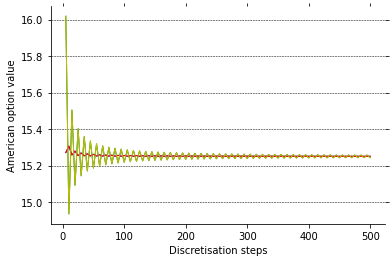

In [42]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

fig, ax = plt.subplots()
plt.plot(disc_num, y_bt, label="Binomial tree", color="g", linewidth=1)
plt.plot(disc_num, y_bt_cv, label="Binomial tree (control variate)", color="b", linewidth=1)
plt.plot(disc_num, y_bt_cv_is, label="Binomial tree (cv + is)", color="r", linewidth=1)
plt.plot(disc_num, y_bt_is, label="Binomial tree (importance sampling)", color="y", linewidth=1)

# formatting the chart
ax.yaxis.grid(True, color='k', linestyle='--', linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='x',which='both',top='off')
plt.tick_params(axis='y',which='both',right='off')
plt.xlabel("Discretisation steps")
plt.ylabel("American option value")
plt.show()

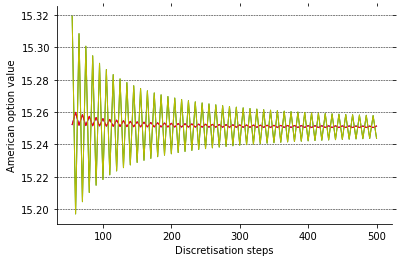

In [43]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

scip = 10

fig, ax = plt.subplots()
plt.plot(disc_num[scip:], y_bt[scip:], label="Binomial tree", color="g", linewidth=1)
plt.plot(disc_num[scip:], y_bt_cv[scip:], label="Binomial tree (control variate)", color="b", linewidth=1)
plt.plot(disc_num[scip:], y_bt_cv_is[scip:], label="Binomial tree (cv + is)", color="r", linewidth=1)
plt.plot(disc_num[scip:], y_bt_is[scip:], label="Binomial tree (importance sampling)", color="y", linewidth=1)


# formatting the chart
ax.yaxis.grid(True, color='k', linestyle='--', linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='x',which='both',top='off')
plt.tick_params(axis='y',which='both',right='off')
plt.xlabel("Discretisation steps")
plt.ylabel("American option value")
plt.show()

In [44]:
# Fast solver for American volatility
def implied_american(df,r,pc,f,fwd,k,price,t,N=100):
    iv = implied_black(df,f,k,price,t,pc)
    fx = binomial_tree(pc,fwd,k,r,iv,t,N,"true")
    #fx = binomial_tree_control_variate(pc,fwd,k,r,iv,t,N,"true","true")  
        
    dx = fx - price
    it = 0
    p = price    
    
    while abs(dx) > 0.00001 and it < 5:
        p = p - dx
        iv = implied_black(df,f,k,p,t,pc)
        fx = binomial_tree(pc,fwd,k,r,iv,t,N,"true")
        #fx = binomial_tree_control_variate(pc,fwd,k,r,iv,t,N,"true","true")  
       
        dx = fx - price
        
        it = it + 1

    return iv

In [45]:
ib = implied_black(df,fwd,strike,bt_put_am,expiry,-1)
ia = implied_american(df,r,-1,fwd,fwd,strike,bt_put_am,expiry)

print(ib)
print(ia)

0.4037520516718719
0.3999999968191812


In [46]:
ratio = [0.95, 1.05]
strikes = fwd * ratio
print(strikes)
vols = [[0.26, 0.25], [0.24, 0.23]]
put_prices = np.zeros((2,2))
call_prices = np.zeros((2,2))

put_vols = np.zeros((2,2))
call_vols = np.zeros((2,2))

put_prices_eu = np.zeros((2,2))
call_prices_eu = np.zeros((2,2))
print(prices)

[0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.9

NameError: name 'prices' is not defined

In [47]:
num = 150
for i,k in enumerate(strikes):
    for j in range(2):
        put_prices[i][j] = binomial_tree_control_variate(-1,fwd,k,r,vols[i][j],expiry,num,"true","true")
        call_prices[i][j] = binomial_tree_control_variate(1,fwd,k,r,vols[i][j],expiry,num,"true","true")        

print(put_prices)

IndexError: list index out of range

In [48]:
q = 0.02
expiry = 1
    
t1 = time.clock()

#div = [[0.25, 3],[0.5, 3], [0.75, 3]]
div = [[0.25, 0],[0.5, 0], [0.75, 0]]
fwd = construct_fwd(S,r,q,div,expiry,num)
fx = fwd(expiry)
df = np.exp(-r*expiry)

for i,k in enumerate(strikes):
    for j in range(2):
        put_vols[i][j] = implied_american(df,r,-1,fx,fwd,k,put_prices[i][j],expiry)
        call_vols[i][j] = implied_american(df,r,1,fx,fwd,k,call_prices[i][j],expiry)        

        put_prices_eu[i][j] = black(df,fx,k,put_vols[i][j],expiry,-1)
        call_prices_eu[i][j] = black(df,fx,k,call_vols[i][j],expiry,1)        
        
print(put_vols)
print(call_vols)

print(put_prices_eu)
print(call_prices_eu)

print(fx-strikes)
print(call_prices_eu - put_prices_eu)

TypeError: unsupported operand type(s) for *: 'int' and 'interp1d'

In [739]:
def f(x, strikes, put_prices_eu, call_prices_eu):
    dy = 0
    
    for i,k in enumerate(strikes):
        for j in range(2):
            dx = x - k + put_prices_eu[i][j] - call_prices_eu[i][j]
            dy = dy + dx * dx
    
    return dy

In [740]:
f(102, strikes, put_prices_eu, call_prices_eu)

0.40422767358925599

In [741]:
from scipy.optimize import minimize

res = minimize(f, fx, args=(strikes,put_prices_eu,call_prices_eu))
x = res.x[0]

In [742]:
print(x)

102.122629262


In [743]:
q = (-np.log(x/S) + r)/expiry

print(q)

0.028995847155


In [55]:
def g():
    q = 0.01

    it = 0

    t1 = time.clock()

    while it < 3:
  
        fwd = S
        fx = fwd
        df = np.exp(-r*expiry)

        for i,k in enumerate(strikes):
            for j in range(2):
                put_vols[i][j] = implied_american(df,r,-1,fwd,fwd,k,put_prices[i][j],expiry)
                call_vols[i][j] = implied_american(df,r,1,fwd,fwd,k,call_prices[i][j],expiry)        

                put_prices_eu[i][j] = black(df,fwd,k,put_vols[i][j],expiry,-1)
                call_prices_eu[i][j] = black(df,fwd,k,call_vols[i][j],expiry,1)        
        
        res = minimize(f, fx, args=(strikes,put_prices_eu,call_prices_eu))
        x = res.x[0]
        q = (-np.log(x/S) + r)/expiry
    
        print(q)
    
        it = it + 1
    
    t2 = time.clock()

    print("Finding the solution takes " + str(t2-t1))

In [56]:
g()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [748]:
%prun g()

0.0279413685683
0.0297534065306
0.0299126457106
Finding the solution takes 0.2752830000000017
 

In [404]:
%prun [binomial_tree(1, fwd, 100, 0.03, 0.2, 1, 250, american="true") for i in range(1000)]